StandardScaler saved as 'scaler.joblib'.
LabelEncoder fitted and applied to 'neighbourhood_cleansed'.
LabelEncoder fitted and applied to 'property_type'.
LabelEncoder for 'neighbourhood_cleansed' saved as 'label_encoder_neighbourhood_cleansed.joblib'.
LabelEncoder for 'property_type' saved as 'label_encoder_property_type.joblib'.
Total sequences: 9000
'neighbourhood_cleansed' index: 0
'property_type' index: 1
Numerical feature indices: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/10


Best Hyperparameters:
model__lstm_units: 100
model__learning_rate: 0.001
model__embedding_property_type_dim: 5
model__embedding_neighbourhood_dim: 11
model__dropout_rate: 0.2
epochs: 10
batch_size: 32
Best Keras model saved as 'best_lstm_model.h5'.
Best hyperparameters saved as 'best_hyperparameters.json'.
Best KerasRegressor saved as 'best_lstm_regressor.pkl'.

Hyperparameter Tuning Results:
                                              params  mean_test_score  \
0  {'model__lstm_units': 50, 'model__learning_rat...         0.719976   
1  {'model__lstm_units': 100, 'model__learning_ra...         0.743307   
2  {'model__lstm_units': 100, 'model__learning_ra...         0.710328   
3  {'model__lstm_units': 50, 'model__learning_rat...        -3.144579   
4  {'model__lstm_units': 100, 'model__learning_ra...         0.649027   

   std_test_score  
0        0.005881  
1        0.009578  
2        0.017021  
3        0.153832  
4        0.014526  
Hyperparameter tuning results saved as 'hype

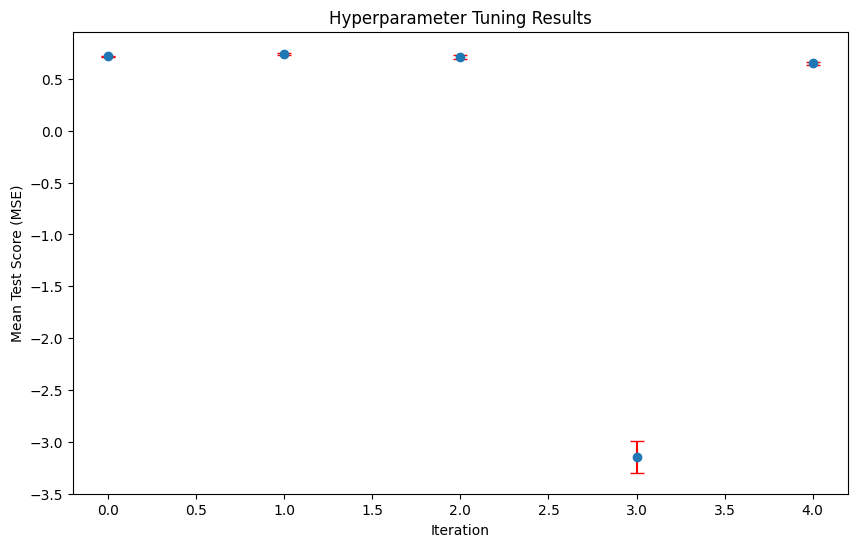

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Test MSE: 195.62374413573266


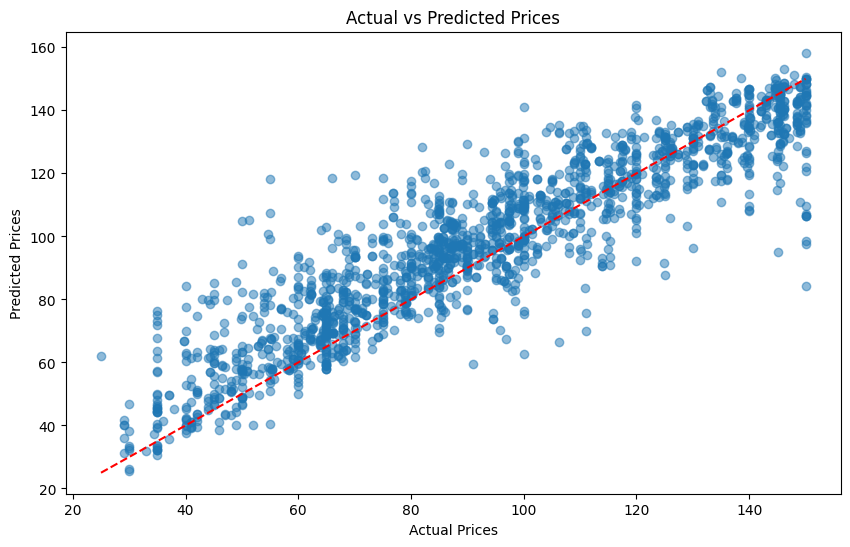

In [21]:
# training_script.py (edited)
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import os
import json
import cloudpickle

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

@tf.keras.utils.register_keras_serializable()
class IndexLayer(tf.keras.layers.Layer):
    def __init__(self, index=None, indices=None, **kwargs):
        super(IndexLayer, self).__init__(**kwargs)
        self.index = index
        self.indices = indices

    def call(self, inputs):
        if self.index is not None:
            return inputs[:, :, self.index]
        elif self.indices is not None:
            return tf.gather(inputs, self.indices, axis=2)
        else:
            raise ValueError("Either 'index' or 'indices' must be provided.")

    def compute_output_shape(self, input_shape):
        batch_size, seq_length, _ = input_shape
        if self.index is not None:
            return (batch_size, seq_length)
        elif self.indices is not None:
            return (batch_size, seq_length, len(self.indices))

# 1. Data Preparation
df = pd.read_csv(r"C:\Users\prabh\Downloads\New folder (2)\sequential_listings_12000.csv")

SEQ_LENGTH = 3
df = df.sort_values(by=['id', 'data_year', 'data_month'])

# Define feature_columns to exclude 'id', 'price', 'data_year', 'data_month'
feature_columns = [col for col in df.columns if col not in ['id', 'price', 'data_year', 'data_month']]

categorical_cols = ['neighbourhood_cleansed', 'property_type']

# Define numerical_cols strictly from feature_columns to avoid extra columns
numerical_cols = df[feature_columns].select_dtypes(include=['int16', 'float16', 'int64', 'float32', 'float64']).columns.tolist()

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
joblib.dump(scaler, 'scaler.joblib')
print("StandardScaler saved as 'scaler.joblib'.")

label_encoders = {}
for col in categorical_cols:
    if df[col].dtype not in ['int16', 'int32', 'int64']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
        print(f"LabelEncoder fitted and applied to '{col}'.")
    else:
        print(f"Column '{col}' is already integer-encoded.")

for col, le in label_encoders.items():
    encoder_filename = f"label_encoder_{col}.joblib"
    joblib.dump(le, encoder_filename)
    print(f"LabelEncoder for '{col}' saved as '{encoder_filename}'.")

# 2. Create sequences
grouped = df.groupby('id')
sequences = []
targets = []

for name, group in grouped:
    group = group.sort_values(by=['data_year', 'data_month'])
    if len(group) < SEQ_LENGTH + 1:
        continue
    for i in range(len(group) - SEQ_LENGTH):
        seq = group.iloc[i:i+SEQ_LENGTH]
        target = group.iloc[i+SEQ_LENGTH]['price']
        sequences.append(seq[feature_columns].values)
        targets.append(target)

sequences = np.array(sequences)
targets = np.array(targets)
print(f"Total sequences: {sequences.shape[0]}")

X_train, X_test, y_train, y_test = train_test_split(
    sequences, targets, test_size=0.2, random_state=42
)

try:
    neighbourhood_index = feature_columns.index('neighbourhood_cleansed')
except ValueError:
    raise ValueError("'neighbourhood_cleansed' not found in feature_columns.")

try:
    property_type_index = feature_columns.index('property_type')
except ValueError:
    raise ValueError("'property_type' not found in feature_columns.")

numerical_indices = [i for i, col in enumerate(feature_columns) if col not in categorical_cols]
print(f"'neighbourhood_cleansed' index: {neighbourhood_index}")
print(f"'property_type' index: {property_type_index}")
print(f"Numerical feature indices: {numerical_indices}")

def build_model(
    lstm_units=50,
    dropout_rate=0.2,
    learning_rate=0.001,
    embedding_neighbourhood_dim=12,
    embedding_property_type_dim=7
):
    input_layer = Input(shape=(SEQ_LENGTH, len(feature_columns)), name='input_layer')

    neighbourhood_input = IndexLayer(index=neighbourhood_index, name='neighbourhood_input')(input_layer)
    property_type_input = IndexLayer(index=property_type_index, name='property_type_input')(input_layer)
    numerical_input = IndexLayer(indices=numerical_indices, name='numerical_input')(input_layer)

    embedding_neighbourhood = Embedding(
        input_dim=df['neighbourhood_cleansed'].nunique(),
        output_dim=embedding_neighbourhood_dim,
        name='embedding_neighbourhood'
    )(neighbourhood_input)

    embedding_property_type = Embedding(
        input_dim=df['property_type'].nunique(),
        output_dim=embedding_property_type_dim,
        name='embedding_property_type'
    )(property_type_input)

    concatenated = Concatenate(axis=-1, name='concatenate')([
        embedding_neighbourhood,
        embedding_property_type,
        numerical_input
    ])

    lstm_out = LSTM(
        units=lstm_units,
        dropout=dropout_rate,
        name='lstm_layer'
    )(concatenated)

    dense1 = Dense(64, activation='relu')(lstm_out)
    dropout1 = Dropout(dropout_rate)(dense1)
    output = Dense(1, activation='linear', name='output_layer')(dropout1)

    model = Model(inputs=input_layer, outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

keras_regressor = KerasRegressor(model=build_model, verbose=2)
param_dist = {
    'model__lstm_units': [50, 100],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0001],
    'model__embedding_neighbourhood_dim': [int(math.sqrt(df['neighbourhood_cleansed'].nunique()))],
    'model__embedding_property_type_dim': [int(math.sqrt(df['property_type'].nunique()))],
    'batch_size': [32, 64],
    'epochs': [10]
}

random_search = RandomizedSearchCV(
    estimator=keras_regressor,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1
)

random_search_result = random_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
for param, value in random_search_result.best_params_.items():
    print(f"{param}: {value}")

best_model = random_search_result.best_estimator_.model_
best_model.save('best_lstm_model.h5')
print("Best Keras model saved as 'best_lstm_model.h5'.")

with open('best_hyperparameters.json', 'w') as f:
    json.dump(random_search_result.best_params_, f, indent=4)
print("Best hyperparameters saved as 'best_hyperparameters.json'.")

with open('best_lstm_regressor.pkl', 'wb') as f:
    cloudpickle.dump(random_search_result.best_estimator_, f)
print("Best KerasRegressor saved as 'best_lstm_regressor.pkl'.")

results = pd.DataFrame(random_search_result.cv_results_)
print("\nHyperparameter Tuning Results:")
print(results[['params', 'mean_test_score', 'std_test_score']])
results.to_csv('hyperparameter_tuning_results.csv', index=False)
print("Hyperparameter tuning results saved as 'hyperparameter_tuning_results.csv'.")

plt.figure(figsize=(10, 6))
plt.errorbar(
    x=range(len(results)),
    y=results['mean_test_score'],
    yerr=results['std_test_score'],
    fmt='o',
    ecolor='r',
    capsize=5
)
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Iteration')
plt.ylabel('Mean Test Score (MSE)')
plt.show()

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"\nTest MSE: {mse}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
